# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [5]:
import requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
from scipy.interpolate import interp1d

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess

import pmdarima
from pmdarima.arima import ndiffs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 6)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10,
#                      'axes.labelweight': 'bold',
                     'figure.figsize': (6, 5)})

In [6]:
params = {'function': 'FX_DAILY',
          'from_symbol': 'CAD',
          'to_symbol': 'USD',
          'outputsize': 'full',
          'apikey': os.environ['ALPHA_API']}

url = "https://www.alphavantage.co/query"
response = requests.get(url, params)

json_data = response.json()
    
# Check if the request was successful, if not raise an
# exception
if 'Error Message' in list(json_data.keys()):    
    raise Exception("Request failed.")

# Create the pandas dataframe (see: pd.read_json() )
data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
transpose().apply(pd.to_numeric).reset_index()

data.columns = ['date', 'open', 'high', 'low', 'close']
data.date = pd.to_datetime(data.date)

data.head()

,date,open,high,low,close
0,2020-05-22,0.7165,0.7171,0.7114,0.7129
1,2020-05-21,0.7191,0.7196,0.7153,0.7167
2,2020-05-20,0.7169,0.7209,0.7163,0.7188
3,2020-05-19,0.7168,0.7210,0.7154,0.7172
4,2020-05-18,0.7090,0.7173,0.7089,0.7173


In [7]:
data.head()

,date,open,high,low,close
0,2020-05-22,0.7165,0.7171,0.7114,0.7129
1,2020-05-21,0.7191,0.7196,0.7153,0.7167
2,2020-05-20,0.7169,0.7209,0.7163,0.7188
3,2020-05-19,0.7168,0.7210,0.7154,0.7172
4,2020-05-18,0.7090,0.7173,0.7089,0.7173


## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [8]:
# the following functions are borrowed from https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Validation {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}",
                fontsize=16)
    ax.set_ylabel(df_train.columns[0])

        
def plot_forecast(ax, df_train, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], '-', c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+len(predictions))
    ax.set_title(f"{len(predictions)}-step forecast",
                    fontsize=16)
    ax.set_ylabel(response_cols)
    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

In [9]:
cad_to_usd = pd.merge(pd.DataFrame(pd.date_range(start='2019-01-01',
                                                 end=datetime.datetime.today()),
                                   columns=['date']),
                      data, how='left')

# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method='ffill')

In [10]:
df = cad_to_usd[['close']]

In [11]:
df

,close
0,0.7334
1,0.7326
2,0.7416
...,...
505,0.7188
506,0.7167
507,0.7129


split data

In [12]:
split = 0.95
split_1 = int(df.shape[0] * split)

train_valid, test = df.iloc[: split_1], df.iloc[split_1:]

split_2 = int(train_valid.shape[0] * split)
train, valid = train_valid.iloc[: split_2], train_valid.iloc[split_2:]

In [13]:
valid

,close
457,0.7082
458,0.7035
459,0.7035
...,...
479,0.7089
480,0.7089
481,0.7089


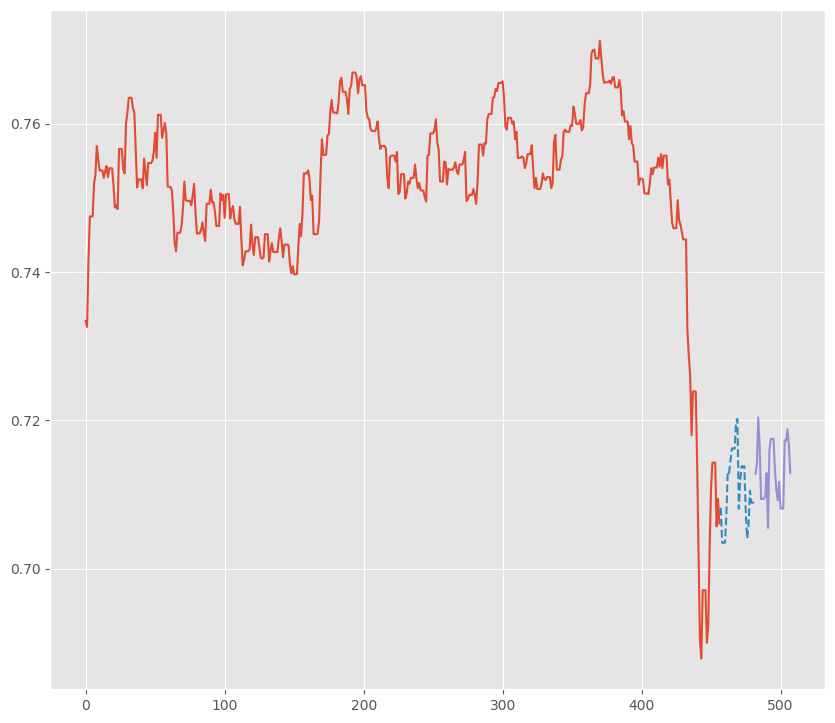

In [14]:
fig, ax = plt.subplots(1, sharex=True, figsize=(10, 9), dpi=100)

ax.plot(train.close, '-')
ax.plot(valid.close, '--')
ax.plot(test.close, '-')

## 6. Research questions



## 7. Data Analysis & Visualizations

ARIMA by hand

find the order of differencing (d) in ARIMA model

The null hypothesis of the ADF test is that the time series is non-stationary.

In [15]:
result = adfuller(train.close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.699352
p-value: 0.846917


P-value is greater than the significance level, I should difference the series

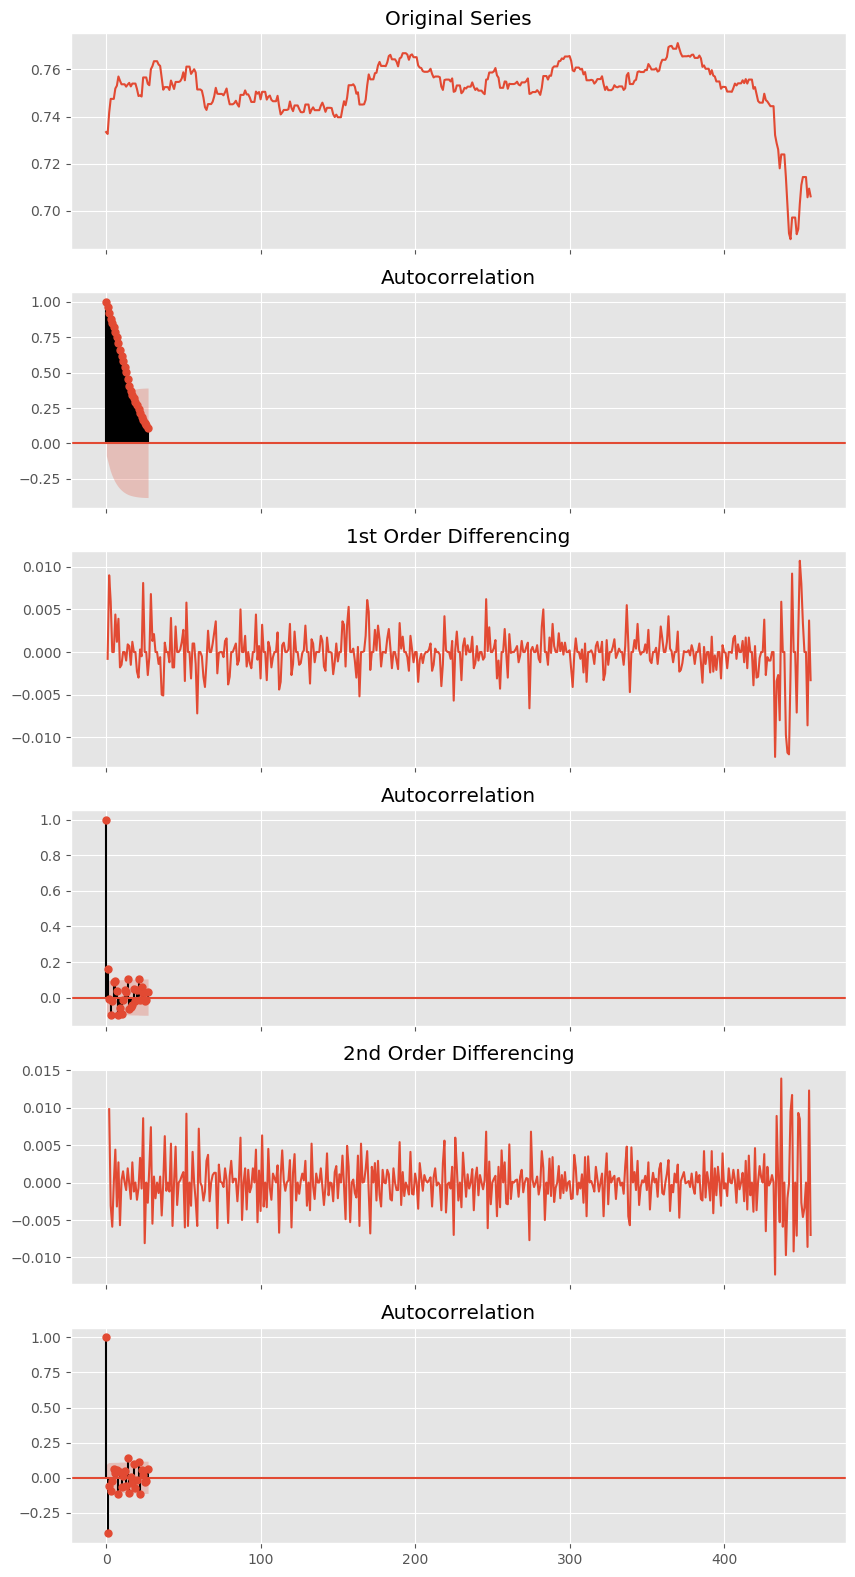

In [16]:
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# original series

fig, axes = plt.subplots(6, sharex=True, figsize=(10, 20), dpi=100)
axes[0].plot(train.close)
axes[0].set_title('Original Series')
plot_acf(train.close, ax=axes[1])

# 1st Differencing
axes[2].plot(train.close.diff())
axes[2].set_title('1st Order Differencing')
plot_acf(train.close.diff().dropna(), ax=axes[3])

# 2nd Differencing
axes[4].plot(train.close.diff().diff())
axes[4].set_title('2nd Order Differencing')
plot_acf(train.close.diff().diff().dropna(), ax=axes[5])

plt.show()

choose d = 2

find the order of the AR term (p)

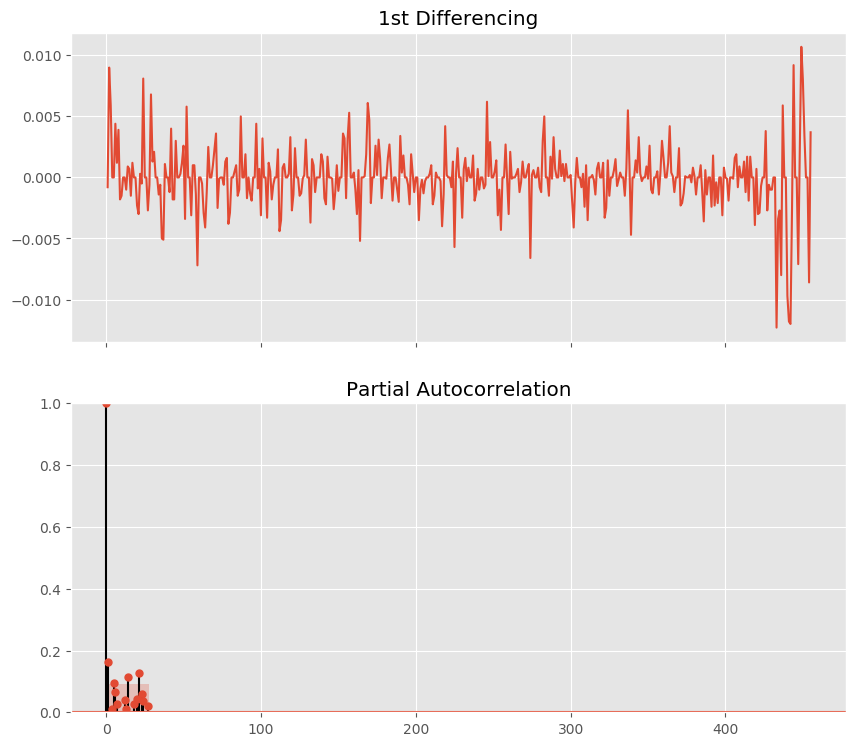

In [135]:

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 9), dpi=100)
axes[0].plot(train.close.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 1))
plot_pacf(train.close.diff().dropna(), ax=axes[1])

plt.show()

choose p = 1

find the order of the MA term (q)

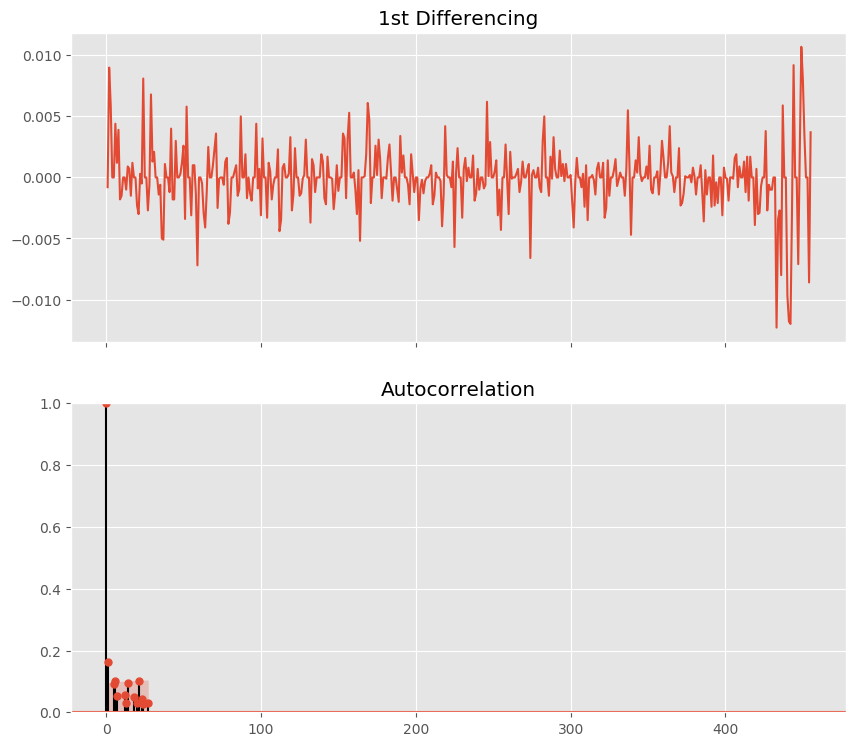

In [132]:
fig, axes = plt.subplots(2, sharex=True, figsize=(10, 9), dpi=100)
axes[0].plot(train.close.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 1))
plot_acf(train.close.diff().dropna(), ax=axes[1])

plt.show()

choose q = 1

fit the arima model

In [153]:
model = ARIMA(train.close, order=(1, 2, 1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                  454
Model:                 ARIMA(1, 2, 1)   Log Likelihood                2084.301
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 21 May 2020   AIC                          -4160.602
Time:                        07:09:22   BIC                          -4144.129
Sample:                             2   HQIC                         -4154.112
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.743e-06   1.03e-06     -1.687      0.092   -3.77e-06    2.82e-07
ar.L1.D2.close     0.1585      0.047      3.406      0.001       0.067       0.250
ma.L1.D2.close    -1.0000      0.007

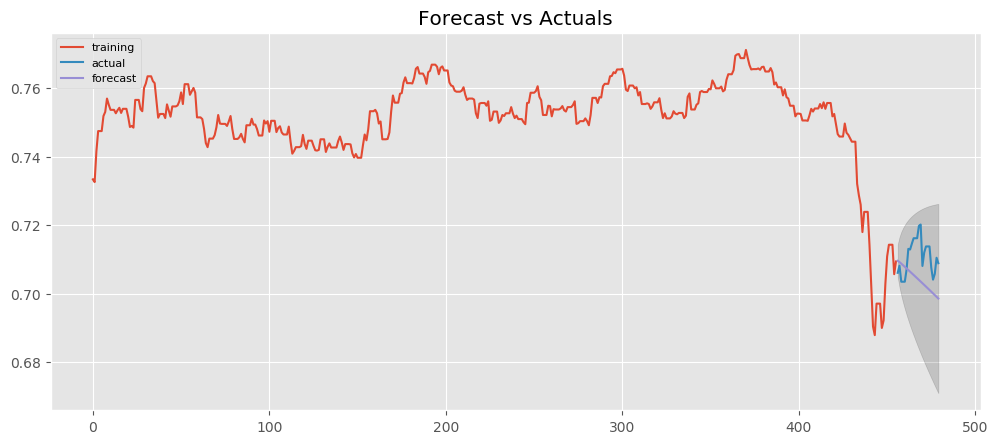

In [160]:
# Forecast
fc, se, conf = model_fit.forecast(valid.size, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  455
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2090.877
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 21 May 2020   AIC                          -4175.755
Time:                        07:14:24   BIC                          -4163.394
Sample:                             1   HQIC                         -4170.885
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.146e-05      0.000     -0.376      0.707      -0.000       0.000
ar.L1.D.close     0.1639      0.046      3.539      0.000       0.073       0.255
                                    Root

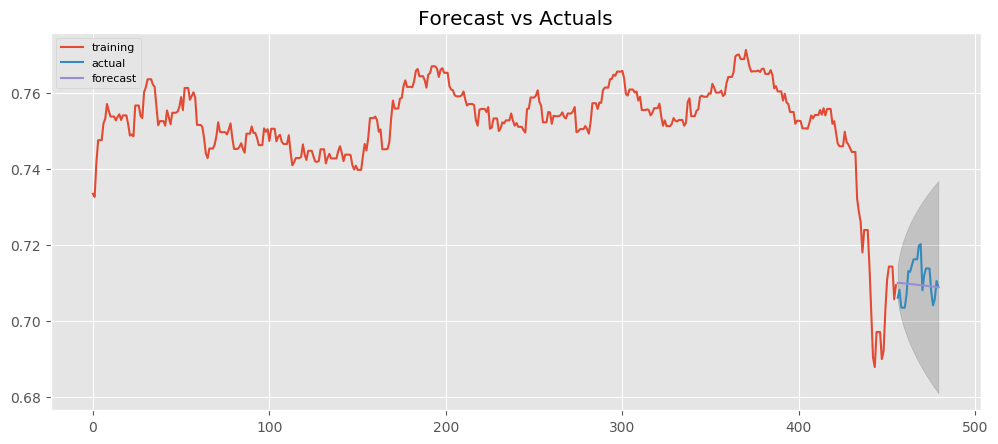

In [171]:
model = ARIMA(train.close, order=(1, 1, 0))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(valid.size, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  455
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2091.123
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 21 May 2020   AIC                          -4176.246
Time:                        07:15:37   BIC                          -4163.885
Sample:                             1   HQIC                         -4171.376
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.161e-05      0.000     -0.386      0.700      -0.000       0.000
ma.L1.D.close     0.1685      0.046      3.692      0.000       0.079       0.258
                                    Root

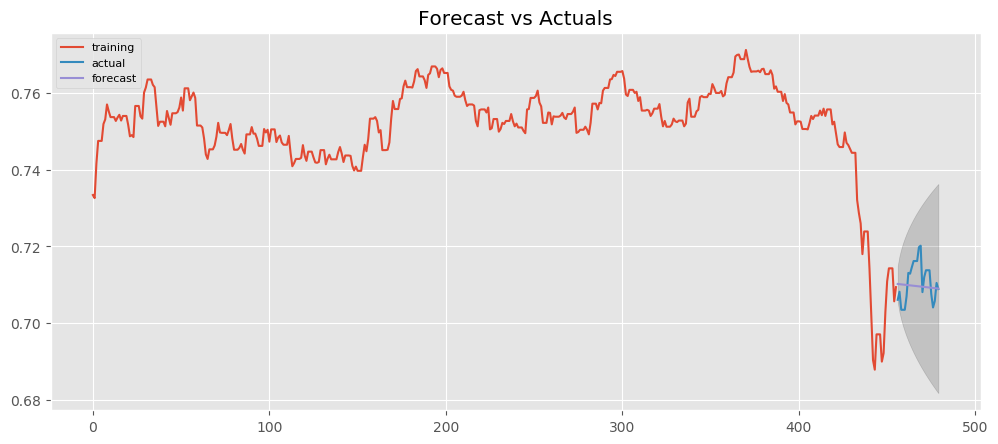

In [174]:
model = ARIMA(train.close, order=(0, 1, 1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(valid.size, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Auto ARIMA Forecast

In [175]:
model = pmdarima.auto_arima(train['close'],
                            start_p=1,
                            start_q=1,
                            test='adf',       
                            max_p=3,
                            max_q=3,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=0,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-4174.233, BIC=-4157.752, Time=0.771 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-4165.405, BIC=-4157.164, Time=0.392 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-4175.755, BIC=-4163.394, Time=0.859 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-4176.245, BIC=-4163.884, Time=0.875 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-4167.197, BIC=-4163.077, Time=0.149 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-4174.284, BIC=-4157.803, Time=0.668 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-4172.034, BIC=-4151.433, Time=0.710 seconds
Total fit time: 4.502 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2091.123
Date:                Thu, 21 Ma

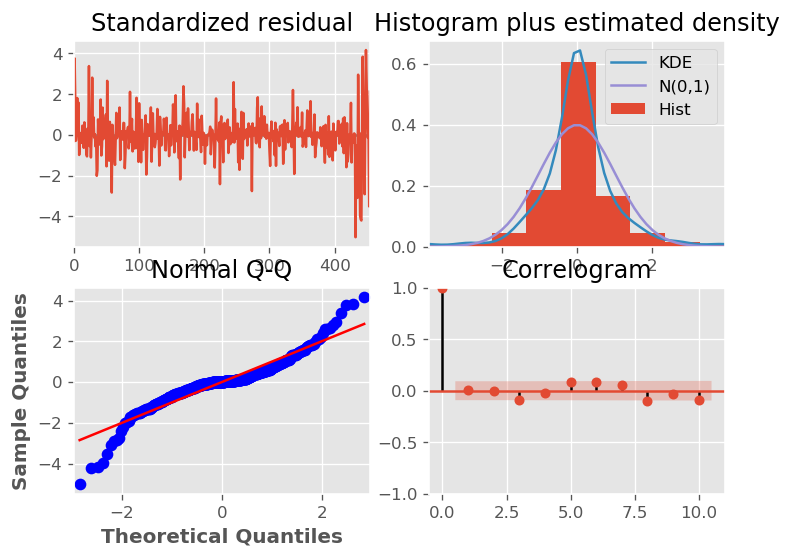

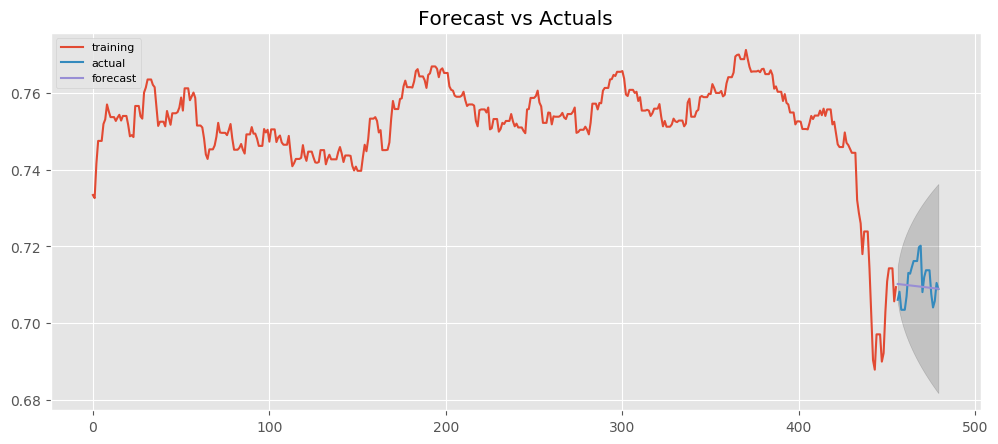

In [179]:
model.plot_diagnostics(figsize=(7,5))
plt.show()



# Forecast
fc, confint = model.predict(n_periods=24, return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Auto SARIMA Forecast

In [138]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pmdarima.auto_arima(train['close'], 
                             start_p=1, 
                             start_q=1,
                             test='adf',
                             max_p=3, 
                             max_q=3, 
                             m=12,
                             start_P=0,
                             seasonal=True,
                             d=None,
                             D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=-4000.438, BIC=-3979.958, Time=11.830 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=-2917.451, BIC=-2909.260, Time=0.476 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=-3947.989, BIC=-3931.605, Time=10.845 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=-3359.453, BIC=-3343.070, Time=6.990 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=-2911.751, BIC=-2907.655, Time=0.142 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=-3844.448, BIC=-3828.065, Time=0.587 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=-3982.587, BIC=-3958.012, Time=16.647 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=-4003.509, BIC=-3978.934, Time=12.962 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=-4004.375, BIC=-3975.704, Time=35.993 seconds
Fit ARIMA(1,0,1)x(2,1,2,12) [intercept=True]; AIC=-3946.822, BIC=-3914.055, Time=27.850 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  456
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                2009.187
Date:                                 Thu, 21 May 2020   AIC                          -4004.375
Time:                                         00:23:44   BIC                          -3975.704
Sample:                                              0   HQIC                         -3993.068
                                                 - 456                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.277e-05   5.38e-05     -0.795      0.426      -0.000    6.26e-05
ar.L1          0.9172      0.011     85.012      0.000       0.896       0.938
ma.L1          0.2531      0.039      6.524      0.000       0.177       0.329
ar.S.L12      -0.2002      0.659     -0.304      0.761      -1.492       1.091
ma.S.L12      -0.5168      0.660     -0.783      0.434      -1.810       0.777
ma.S.L24      -0.2570      0.513     -0.501      0.617      -1.263       0.749
sigma2      6.652e-06   3.55e-07     18.760      0.000    5.96e-06    7.35e-06
===================================================================================
Ljung-Box (Q):                       72.59   Jarque-Bera (JB):               487.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -1.00
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

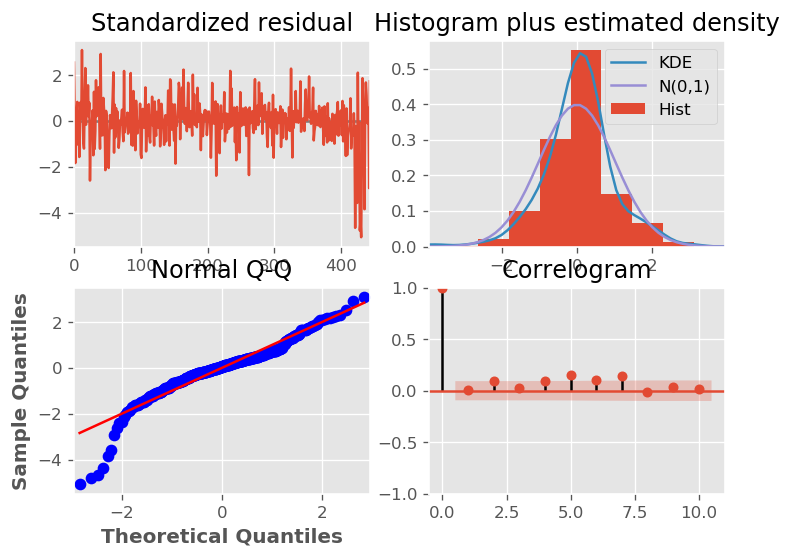

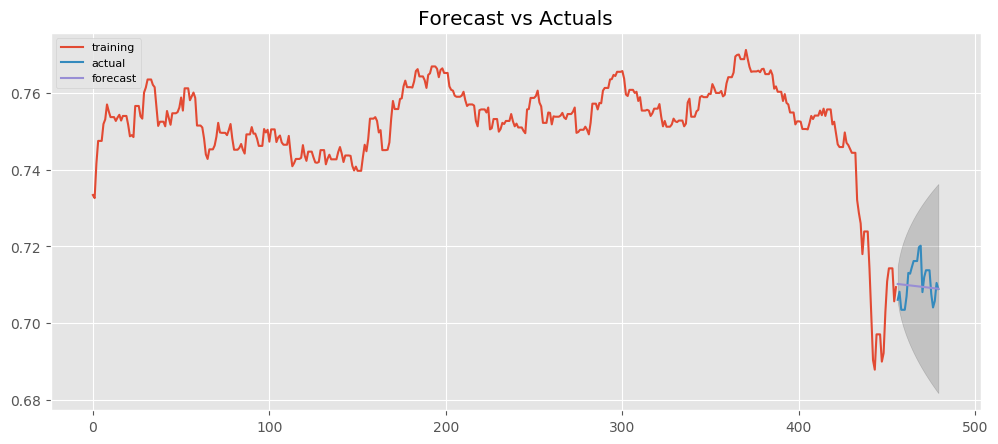

In [180]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

# Forecast
fc, confint = model.predict(n_periods=24, return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Classic supervise learning

Random Forests

In [181]:
lag = 15  # you can vary the number of lagged features in the model
n_splits = 8  # you can vary the number of train/validation splits
response_col = ['close']
df_lag = lag_df(cad_to_usd[['close']], lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model

cv = cross_validate(model,
                    X = df_lag.drop(columns=response_col),
                    y = df_lag[response_col[0]],
                    cv=tscv,
                    return_train_score=True)

pd.DataFrame({'split': range(n_splits),
              'train_r2': cv['train_score'],
              'validation_r2': cv['test_score']}).set_index('split')

,train_r2,validation_r2
split,,
0,0.934494,-7.970342
1,0.966232,-1.420864
2,0.974621,0.538188
...,...,...
5,0.985790,0.725016
6,0.984053,0.864924
7,0.986993,-0.162321


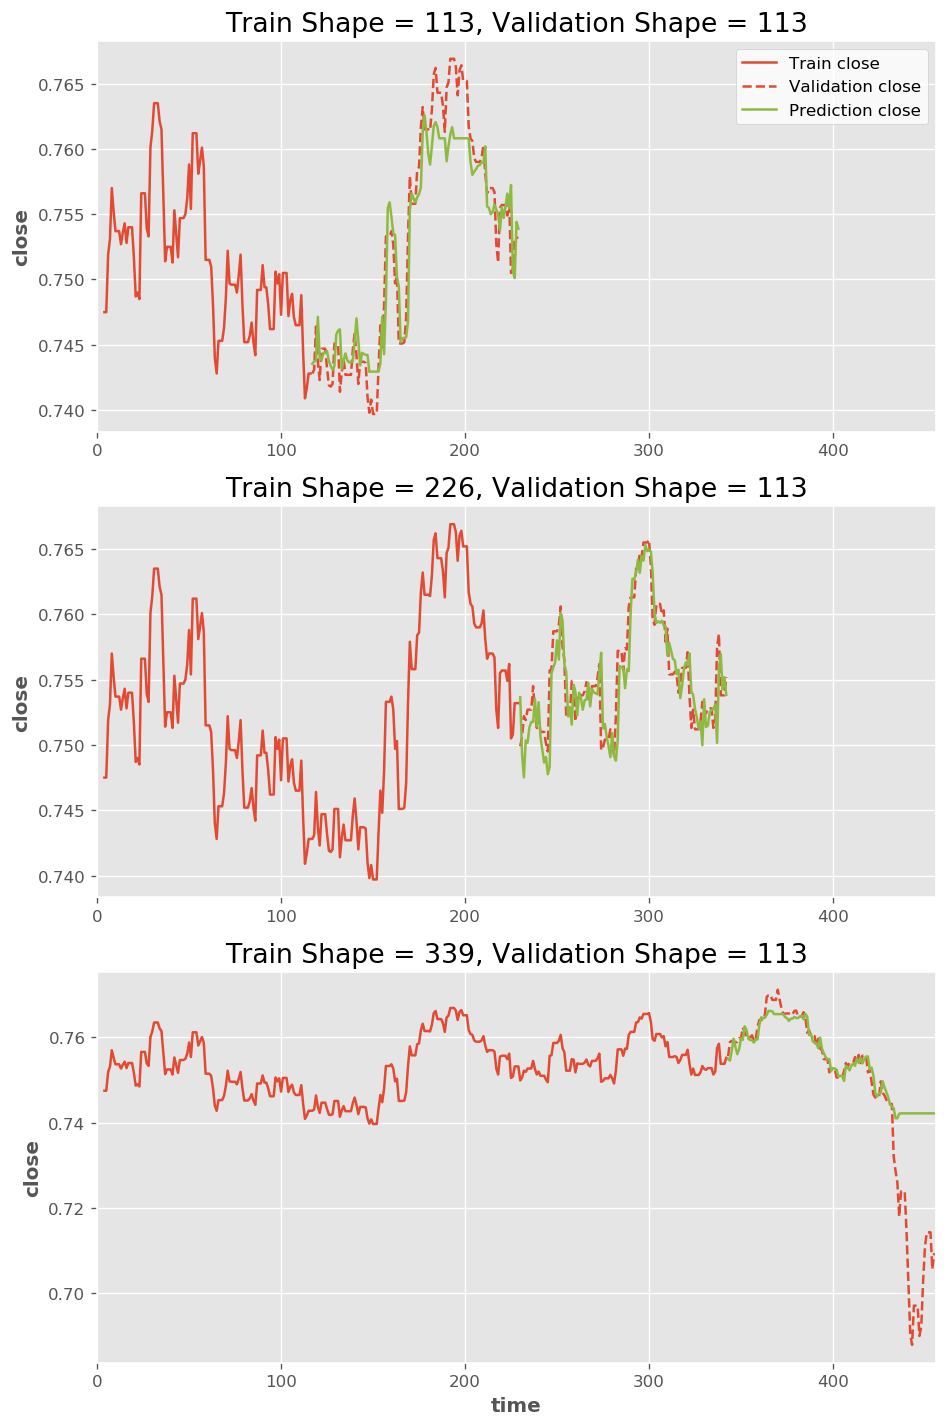

In [185]:
fig, ax = plt.subplots(n_splits, 1, figsize=(8, 4*n_splits))
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    predictions = model.predict(df_test.drop(columns=response_col))[:,None]

    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time')
fig.tight_layout()

In [186]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

,cv_mean,cv_std
lag,,
2,0.691,0.195
4,0.689,0.194
17,0.686,0.185
...,...,...
18,0.680,0.182
15,0.680,0.175
9,0.678,0.180


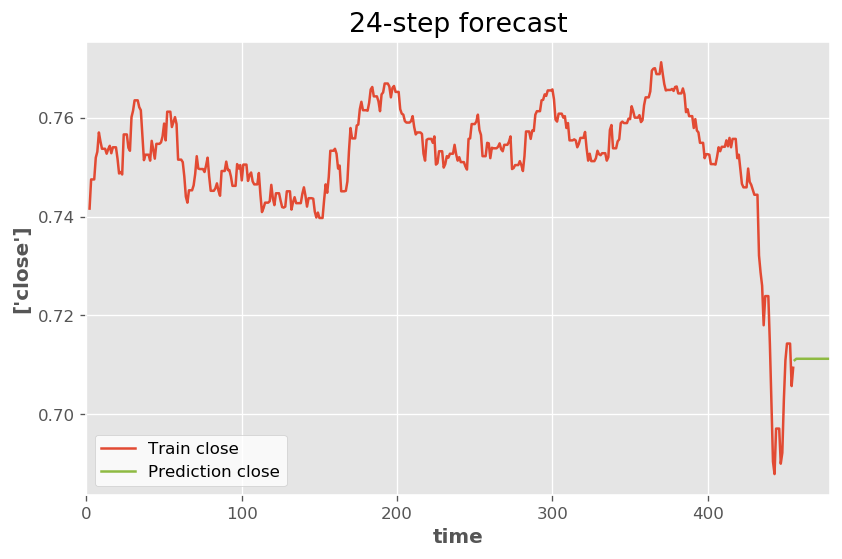

In [188]:
lag = 2
n = 24  # number of steps to forecast
response_col = ['close']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(train, lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

Differencing

Stationarity means that the mean and variance of the series is finite and does not change over time. Thus, it implies some stability in the statistical properties of the time series.

In [190]:
ndiffs(train)

1

In [290]:
train_trans = np.log(train).diff().dropna()

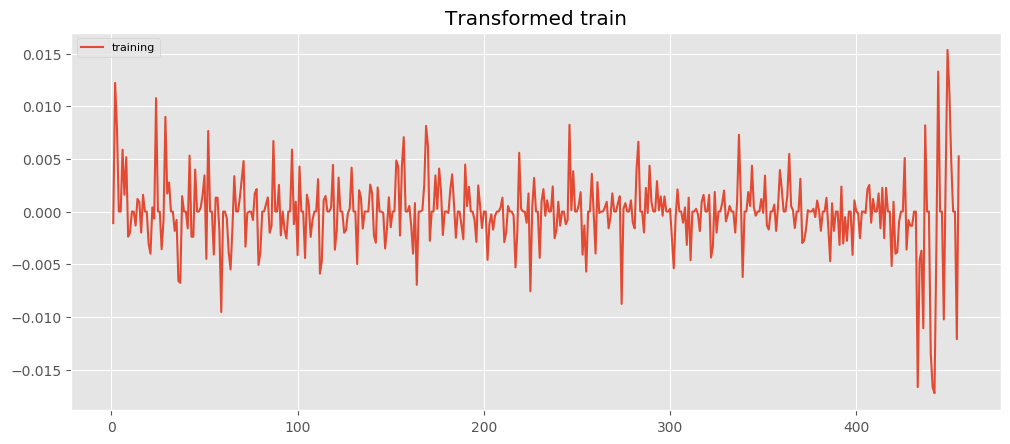

In [196]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_trans.close, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

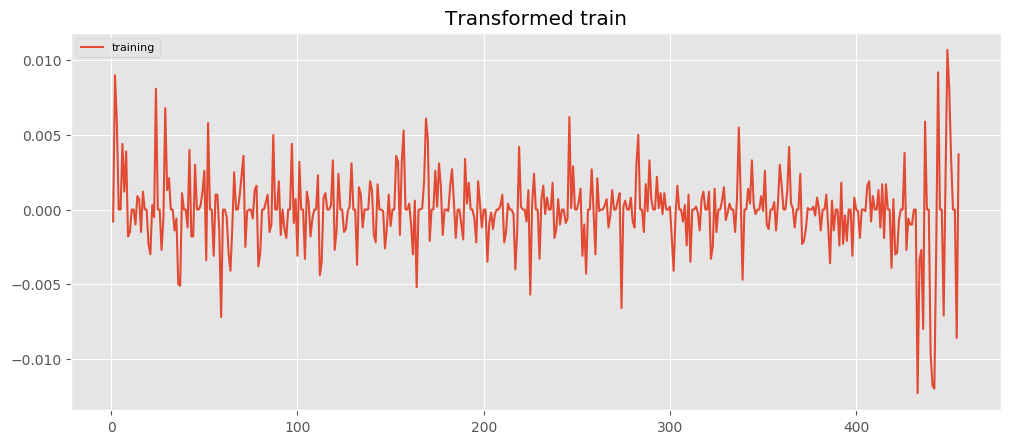

In [197]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.diff().close, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [313]:
trans = train.copy()

In [315]:
trans['trans_1'], lamb = stats.boxcox(train.close)

In [316]:
trans['trans'] = trans.trans_1.diff()

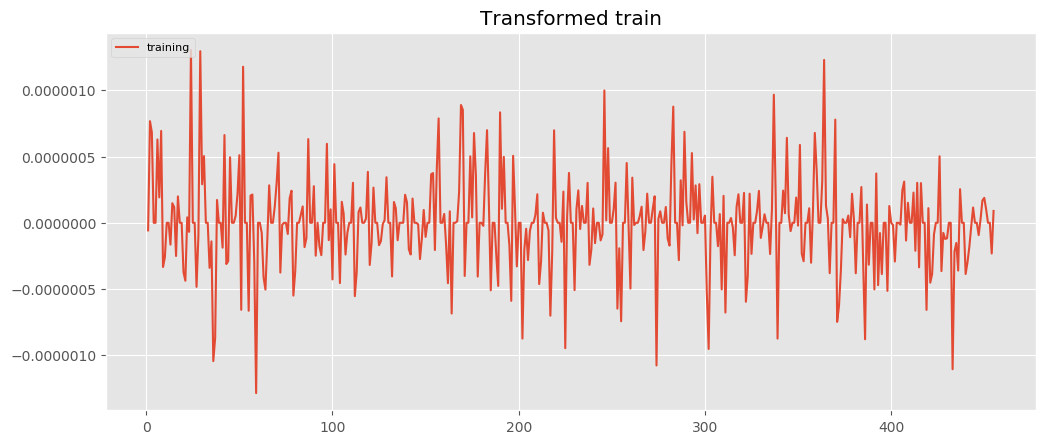

In [294]:

plt.figure(figsize=(12,5), dpi=100)
plt.plot(trans.trans, label='training')

plt.title('Transformed train')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [215]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model
# search loop
l = []
cv_mean = []
cv_std = []
response_col = ['close']
for lag in range(1, 21):
    df_lag = lag_df(train_trans, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col[0]],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

,cv_mean,cv_std
lag,,
13,-0.104,0.021
15,-0.108,0.014
14,-0.108,0.046
...,...,...
11,-0.116,0.008
19,-0.121,0.010
20,-0.121,0.004


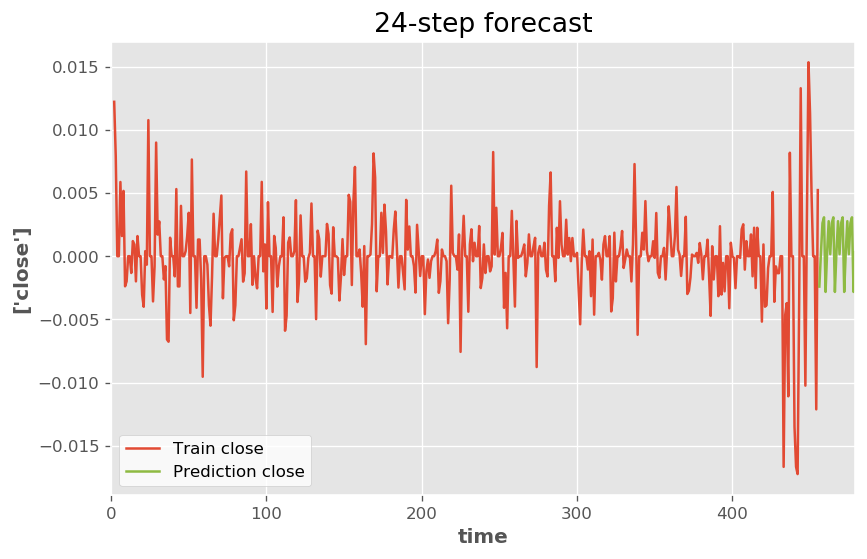

In [298]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(train_trans, lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

Text(0.5, 0, 'time')

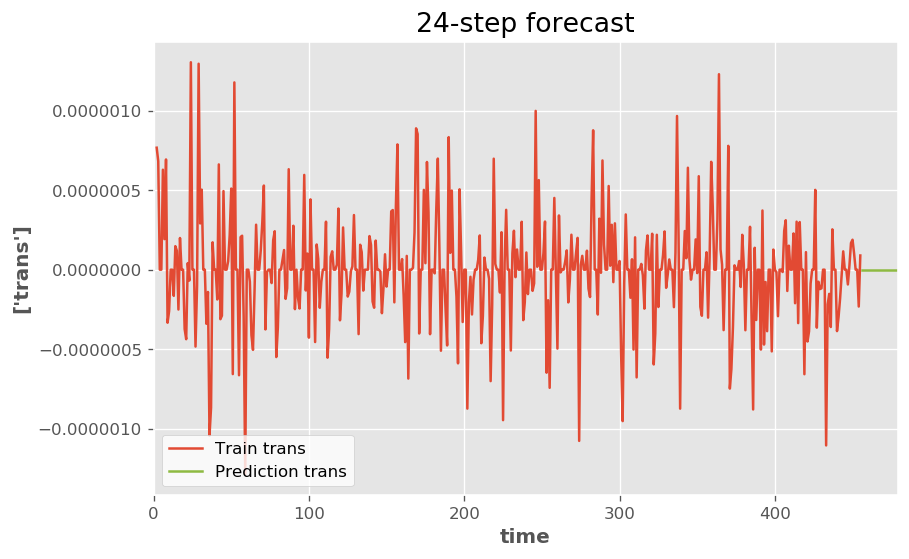

In [304]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['trans']
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(trans[['trans']], lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time')

In [305]:
np.cumsum(predictions)

array([-1.87654150e-09, -3.75308301e-09, -5.62962451e-09, -7.50616602e-09,
       -9.38270752e-09, -1.12592490e-08, -1.31357905e-08, -1.50123320e-08,
       -1.68888735e-08, -1.87654150e-08, -2.06419565e-08, -2.25184981e-08,
       -2.43950396e-08, -2.62715811e-08, -2.81481226e-08, -3.00246641e-08,
       -3.19012056e-08, -3.37777471e-08, -3.56542886e-08, -3.75308301e-08,
       -3.94073716e-08, -4.12839131e-08, -4.31604546e-08, -4.50369961e-08])

In [317]:
trans.trans_1.iloc[0]

-0.031506554622409394

In [318]:
np.exp(np.log(lamb*(trans.trans_1.iloc[-1] + np.cumsum(predictions))+ 1)/lamb)

array([0.709328  , 0.70925578, 0.70918334, 0.70911066, 0.70903776,
       0.70896462, 0.70889125, 0.70881765, 0.70874381, 0.70866973,
       0.70859542, 0.70852086, 0.70844607, 0.70837103, 0.70829574,
       0.70822021, 0.70814443, 0.7080684 , 0.70799211, 0.70791558,
       0.70783879, 0.70776174, 0.70768443, 0.70760686])

In [319]:
predict = np.exp(np.log(lamb*(trans.trans_1.iloc[-1] + np.cumsum(predictions))+ 1)/lamb)

In [320]:
predict = pd.Series(predict, index=valid.index)

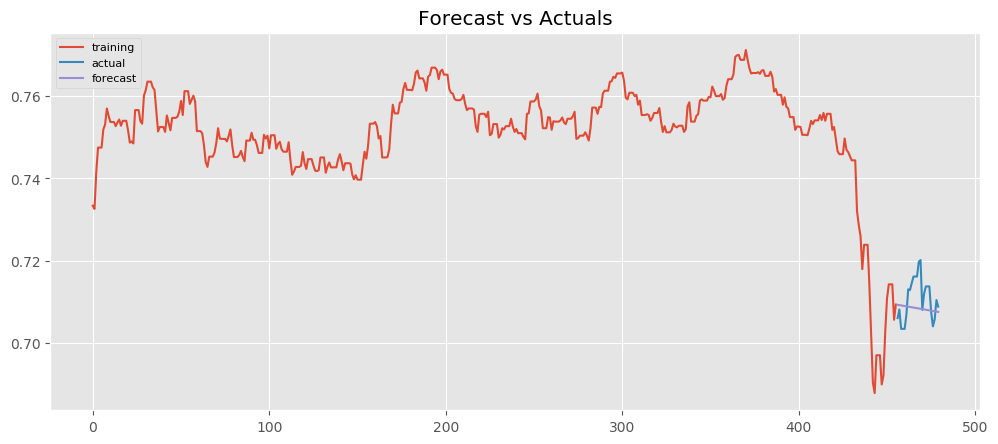

In [321]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [36]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
# calculation loop
k_dict = {'k':[], 'train_error':[], 'cv_error': []}

for k in np.arange(1, 51):
    model = KNeighborsRegressor(n_neighbors=k).fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])
    k_dict['k'].append(k)    
    k_dict['train_error'].append(mean_squared_error(model.predict(df_lag.drop(columns=response_col)),
                                                 df_lag[response_col[0]])) 
    k_dict['cv_error'].append(-cross_val_score(model,
                                                  df_lag.drop(columns=response_col),
                                                  df_lag[response_col[0]],
                                              scoring='neg_mean_squared_error',
                                                  cv=tscv).mean())

k_df = pd.DataFrame(k_dict)

In [37]:
np.argmin(k_dict['cv_error'])

1

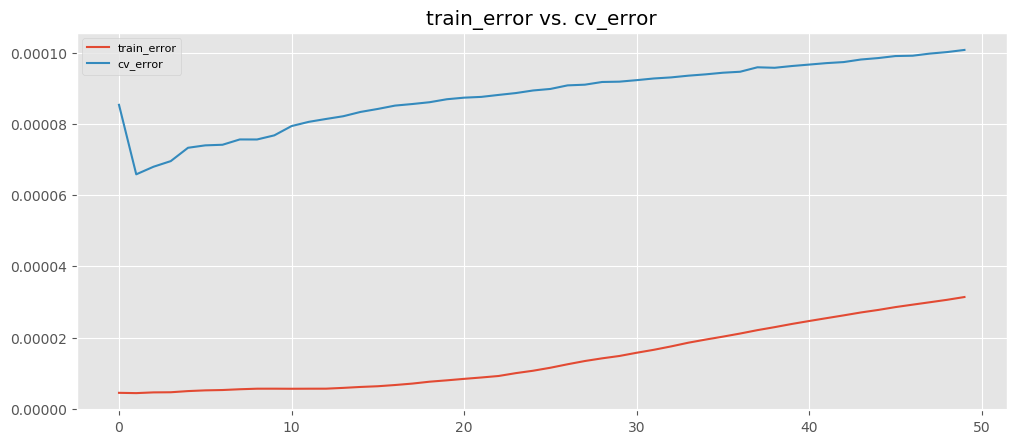

In [39]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(k_df.train_error, label='train_error')
plt.plot(k_df.cv_error, label='cv_error')

plt.title('train_error vs. cv_error')
plt.legend(loc='upper left', fontsize=8)
plt.show()

choose k = 2

Text(0.5, 0, 'time')

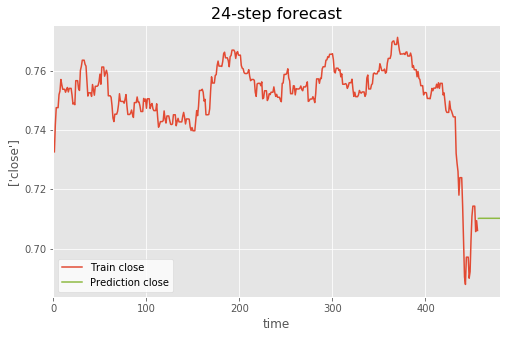

In [40]:
lag = 1
n = 24  # number of steps to forecast


response_col = ['close']

df_lag = lag_df(train, lag, response_col).dropna()

fig, ax = plt.subplots(1, 1, figsize=(8,5))

model = KNeighborsRegressor(n_neighbors=2).fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col[0]])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*train.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n) # custom forecast function

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time')

In [370]:
lag = 1
n = 24  # number of steps to forecast
response_col = ['close']
df_lag = lag_df(train, lag, response_col).dropna()
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter

# calculation loop
k_dict = {'k':[], 'train_error':[], 'cv_error': []}
for k in np.arange(1, 51):
    model = lowess(df_lag.iloc[:, 1],
                   df_lag[response_col[0]],frac=k/df_lag.shape[0])
    lowess_x = list(zip(*model))[0]
    lowess_y = list(zip(*model))[1]
    f = interp1d(lowess_x, lowess_y, bounds_error=False)

    xnew = [i/10. for i in range(400)]    
    for train_index, test_index in tscv.split(df_lag.iloc[:, 1]):


    
    k_dict['k'].append(k)    
    k_dict['train_error'].append(1 - model.score(df_lag.iloc[:, 1],
                                                 df_lag[response_col[0]])) 
    k_dict['cv_error'].append(1 - cross_val_score(model,
                                                  df_lag.iloc[:, 1],
                                                  df_lag[response_col[0]],
                                                  cv=5).mean())
k_df = pd.DataFrame(k_dict)

AttributeError: 'numpy.ndarray' object has no attribute 'score'

In [42]:
model = lowess(df_lag.iloc[:, 1],
               df_lag[response_col[0]])
lowess_x = list(zip(*model))[0]
lowess_y = list(zip(*model))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [48]:
mean_squared_error(lowess_y, df_lag[response_col[0]])

0.000339054562114519

In [50]:
df_lag[response_col[0]]

1      0.7326
2      0.7416
3      0.7475
        ...  
454    0.7057
455    0.7094
456    0.7061
Name: close, Length: 456, dtype: float64

In [53]:
pred_valid = [df_lag[response_col[0]].iloc[-1]]
for i in range(valid.shape[0]):
    pred_valid.append(f(pred_valid[-1]))
predict = pd.Series(pred_valid[1:], index=valid.index)


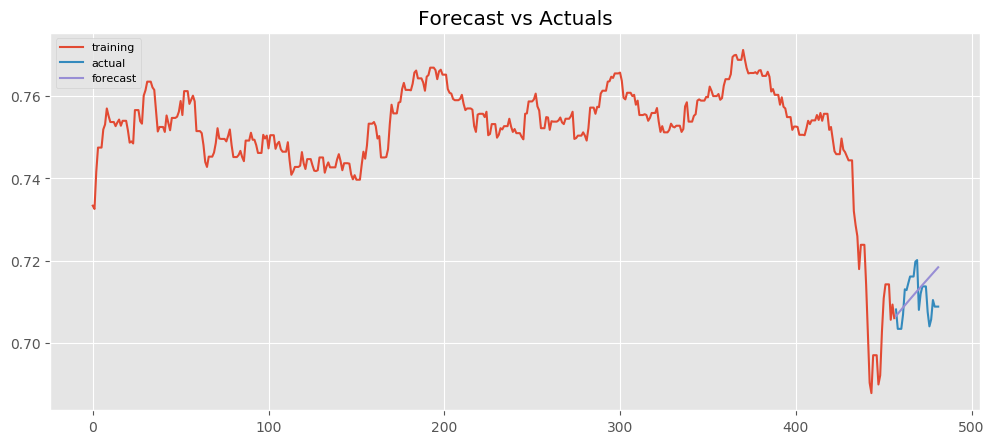

In [54]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.close, label='training')
plt.plot(valid.close, label='actual')
plt.plot(predict, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 8. Summary and conclusions
